# Event Handling and Interactive Plots

In the following sections of this IPython Notebook we be looking at the following:

* matplotlib's event loop support
* Basic Event Handling
  * List of supported events
  * Mouse events
  * Limitations of the IPython Notebook backend
  * Keyboard events
  * Axes and Figures events
  * Object picking
* Compound Event Handling
  * Toolbar
  * Interactive panning and zooming of figures

Warm-up proceedures:

In [1]:
import matplotlib
matplotlib.use('nbagg')

Notice that we've left out the following line from our usual notebook prelude:

```
%matplotlib inline
```

We've disabled inline so that we get access to the interactive mode. More on that later :-)

Let's continue with the necessary imports:

In [2]:
import random
import sys
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from typecheck import typecheck

sys.path.append("../lib")
import topo

Let's set up our colors for this notebook:

In [3]:
pallete_name = "husl"
colors = sns.color_palette(pallete_name, 8)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors) 

## Event Loop Basics

Before we look at matplotlib's event loop support, let's do a quick survey of event loops and get a refresher on how they work. Here's a pretty simple "event" loop:

```python
while True:
    pass
```

That loop is not going be worth our while to execute in this notebook :-) So let's do another one, almost as simple, that has a good chance of exiting in under a minute:

In [4]:
x = True
while x:
    time.sleep(1)
    if random.random() < 0.15:
        x = False

This loop only handles one "event": the change of a value from ``True`` to ``False``. That loop will continue to run until the condition for a false value of ``x`` is met (a random float under a particular threshold).

So what relation do these simple loops have with the loops that power toolkits like GTK and Qt or frameworks like Twisted and Tornado? Usually event systems have something like the following:
 * a way to start the event loop
 * a way to stop the event loop
 * providing a means for registering events
 * providing a means for responding to events

During each run, a loop will usually check a data structure to see if there are any new events that have occurred since the last time it looped. In a network event system, each loop might check to see if any file descriptors are ready for reading or writing. In a GUI toolkit, each look might check to see if any clicks or button presses had occurred.

Given the simple criteria above, let's try building a minimally demonstrative, if not useful, event loop. To keep this small, we're not going to integrate with socket or GUI events. The event that our loop will respond to will be quite minimal indeed.

In [5]:
class EventLoop:
    def __init__(self):
        self.command = None
        self.status = None
        self.handlers = {"interrupt": self.handle_interrupt}
        self.resolution = 0.1

    def loop(self):
        self.command = "loop"
        while self.command != "stop":
            self.status = "running"
            time.sleep(self.resolution)
            
    def start(self):
        self.command = "run"
        try:
            self.loop()
        except KeyboardInterrupt:
            self.handle_event("interrupt")
            
    def stop(self):
        self.command = "stop"

    @typecheck
    def add_handler(self, fn: callable, event: str):
        self.handlers[event] = fn

    @typecheck
    def handle_event(self, event: str):
        self.handlers[event]()
        
    def handle_interrupt(self):
        print("Stopping event loop ...")
        self.stop()            

Here's what we did:

* Created a class that maintains a data structure for event handlers
* We also added a default handler for the "interrupt" event
* Created a loop method
* Created methods for starting and stopping the loop (via an attribute change)
* In our ``start`` method, we check for an interrupt signal, and fire off an interrupt handler for said signal
* Created a method for adding event handlers to the handler data structure (should we want to add more)

Let's creat an instance and start it up:

In [6]:
el = EventLoop()
el.start()

Stopping event loop ...


When you evaluate that cell, IPython will display the usual indicator that a cell is continuing to run:

```
In [*]:
```

As soon as you're satisfied that the loop is merrily looping, go up to the IPython Notebook menu and select "Kernel" -> "Interrupt". The cell with the loop in it should finish, with not only an ``In`` number instead of an asterisk, but our interrupt handler should have printed out a status message as well.

Though this event loop is fairly different from those that power networking libraries or GUI toolkits, it's *very* close (both in nature and code) to the default event loops matplotlib provides for its canvas objects. As such, this is a perfect starting place for your deeper understanding of matplotlib. To continue in this vein, reading the matplotlib backend source code would serve you well.

## Standard Event Handling in matplotlib

With some event loop knowledge under our belts, we're ready to start working with matplotlib events.

Below is the list of supported events in matplotlib as of version 1.4:


| Event name              | Class and description                                |
|-------------------------|------------------------------------------------------|
|``button_press_event``   | ``MouseEvent`` - mouse button is pressed             |
|``button_release_event`` | ``MouseEvent`` - mouse button is released            |
|``draw_event``	          | ``DrawEvent`` - canvas draw                          |
|``key_press_event``      | ``KeyEvent`` - key is pressed                        |
|``key_release_event``    | ``KeyEvent`` - key is released                       |
|``motion_notify_event``  | ``MouseEvent`` - mouse motion                        |
|``pick_event``           | ``PickEvent`` - an object in the canvas is selected  |
|``resize_event``	      | ``ResizeEvent`` - figure canvas is resized           |
|``scroll_event``	      | ``MouseEvent`` - mouse scroll wheel is rolled        |
|``figure_enter_event``   | ``LocationEvent`` - mouse enters a new figure        |
|``figure_leave_event``   | ``LocationEvent`` - mouse leaves a figure            |
|``axes_enter_event``	  | ``LocationEvent`` - mouse enters a new axes          |
|``axes_leave_event``	  | ``LocationEvent`` - mouse leaves an axes             |


We'll discuss some of these below in more detail. With that information in hand, you should be able to tackle problems with any of the supported events in matplotlib.

### Mouse Events

In the next cell, we will define a couple of callback functions, and then connet these to specific canvas events.

Go ahead and render the cell then click on the display plot a couple of times:


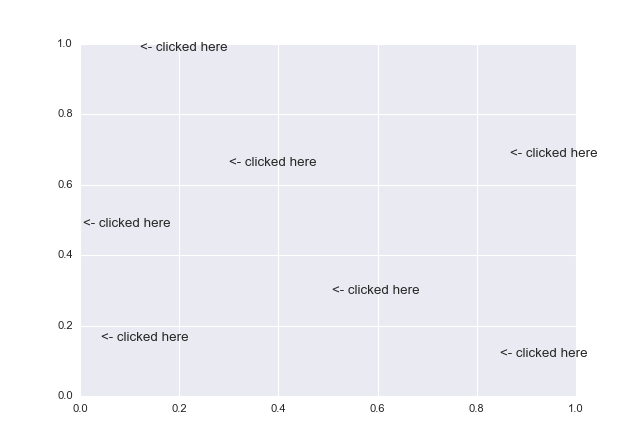

In [7]:
def press_callback(event):
    event.canvas.figure.text(event.xdata, event.ydata, '<- clicked here')
    
def release_callback(event):
    event.canvas.figure.show()
    
(figure, axes) = plt.subplots()
press_conn_id = figure.canvas.mpl_connect('button_press_event', press_callback)
release_conn_id = figure.canvas.mpl_connect('button_release_event', release_callback)
plt.show()

Our callbacks display a little note close to each $(x, y)$ coordinate where we clicked (the location is not exact due to font-sizing, etc.) If we use a graphical indication as opposed to a textual one, we can get much better precision:


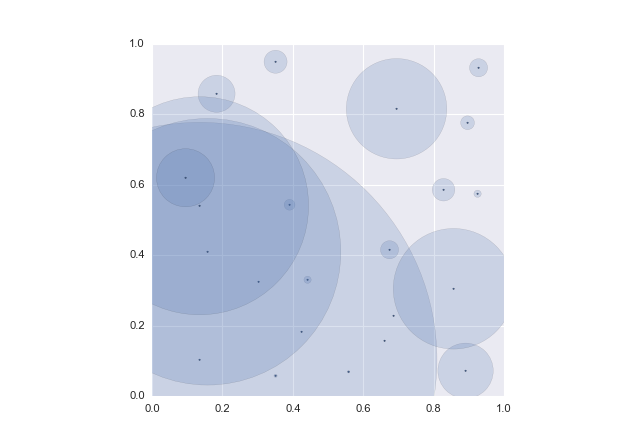

In [8]:
class Callbacks:
    def __init__(self):
        (figure, axes) = plt.subplots()
        axes.set_aspect(1)
        figure.canvas.mpl_connect('button_press_event', self.press)
        figure.canvas.mpl_connect('button_release_event', self.release)

    def start(self):
        plt.show()

    def press(self, event):
        self.start_time = time.time()

    def release(self, event):
        self.end_time = time.time()
        self.draw_click(event)
        
    def draw_click(self, event):
        size = 4 * (self.end_time - self.start_time) ** 2
        c1 = plt.Circle([event.xdata, event.ydata], 0.002,)
        c2 = plt.Circle([event.xdata, event.ydata], 0.02 * size, alpha=0.2)
        event.canvas.figure.gca().add_artist(c1)
        event.canvas.figure.gca().add_artist(c2)
        event.canvas.figure.show()

cbs = Callbacks()
cbs.start()

As you can see, we changed the callback to display a cicle instead of text. If you choose to press and hold, and then release a bit later, you will see that a second, transparent circle is displayed. The longer you hold, the larger the second transpent circle will be.

Let's try something a little more involved, adapted from the [line-drawing example](http://matplotlib.org/users/event_handling.html#event-attributes) in the "Event handling and picking" chapter of the matplotlib [Advanced Guide](http://matplotlib.org/users/developer.html):


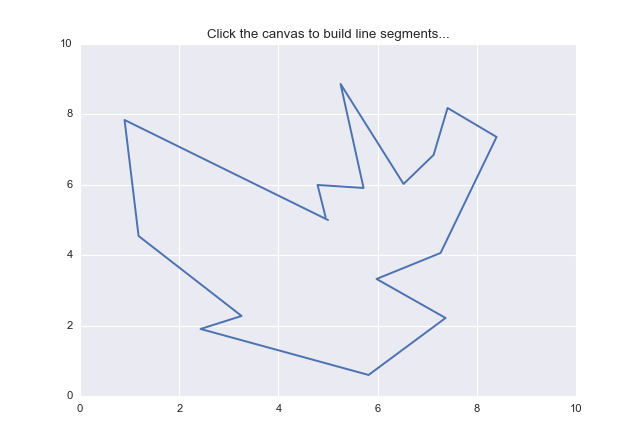

In [9]:
class LineBuilder:
    def __init__(self, event_name='button_press_event'):
        (self.figure, self.axes) = plt.subplots()
        plt.xlim([0, 10])
        plt.ylim([0, 10])
        (self.xs, self.ys) = ([5], [5])
        (self.line,) = self.axes.plot(self.xs, self.ys)
        self.axes.set_title('Click the canvas to build line segments...')
        self.canvas = self.figure.canvas
        self.conn_id = self.canvas.mpl_connect(event_name, self.callback)

    def start(self):
        plt.show()

    def update_line(self, event):
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)

    def callback(self, event):
        if event.inaxes != self.line.axes:
            return
        self.update_line(event)
        self.canvas.draw()

lb = LineBuilder()
lb.start()

For dessert, here's the [slider demo](http://matplotlib.org/users/screenshots.html#slider-demo) from matplotlib: 


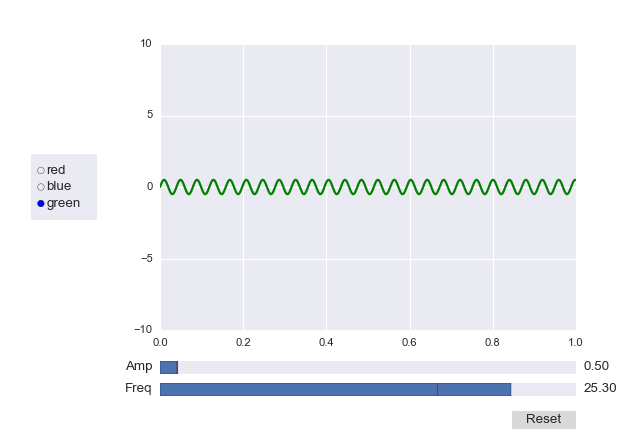

In [10]:
from matplotlib import widgets
from matplotlib.backend_bases import MouseEvent

def get_sine_data(amplitude=5, frequency=3, time=None):
    return amplitude * np.sin(2 * np.pi * frequency * time)

class SineSliders:
    def __init__(self, amplitude=5, frequency=3):
        (self.figure, _) = plt.subplots()
        self.configure()
        self.a0 = amplitude
        self.f0 = frequency
        self.time = np.arange(0.0, 1.0, 0.001)
        self.data = get_sine_data(
            amplitude=self.a0, frequency=self.f0, time=self.time)
        (self.line,) = plt.plot(self.time, self.data, lw=2, color='red')
        self.axes_amp  = plt.axes([0.25, 0.15, 0.65, 0.03])
        self.axes_freq = plt.axes([0.25, 0.1, 0.65, 0.03])
        self.setup_sliders()
        self.setup_reset_button()
        self.setup_color_selector()

    def start(self):
        plt.show()

    def configure(self):
        plt.subplots_adjust(left=0.25, bottom=0.25)
        plt.axis([0, 1, -10, 10])

    def setup_sliders(self):
        self.slider_amp = widgets.Slider(
            self.axes_amp, 'Amp', 0.1, 10.0, valinit=self.a0)
        self.slider_freq = widgets.Slider(
            self.axes_freq, 'Freq', 0.1, 30.0, valinit=self.f0)
        self.slider_freq.on_changed(self.update)
        self.slider_amp.on_changed(self.update)
        
    def setup_reset_button(self):
        reset_axes = plt.axes([0.8, 0.025, 0.1, 0.04])
        reset_button = widgets.Button(reset_axes, 'Reset', hovercolor='0.975')
        reset_button.on_clicked(self.reset)
        
    def setup_color_selector(self):
        radio_axes = plt.axes([0.025, 0.5, 0.15, 0.15], aspect=1)
        radio_select = widgets.RadioButtons(
            radio_axes, ('red', 'blue', 'green',), active=0)
        radio_select.on_clicked(self.switchcolor)
        
    def update(self, val):
        self.data = get_sine_data(self.slider_amp.val,
                                  self.slider_freq.val,
                                  self.time)
        self.line.set_ydata(self.data)
        self.figure.canvas.draw()

    def reset(self, event):
        self.slider_freq.reset()
        self.slider_amp.reset()

    def switchcolor(self, label):
        self.line.set_color(label)
        self.figure.canvas.draw()

sldrs = SineSliders(amplitude=0.5, frequency=20)
sldrs.start()

### Limitations of *nbagg*

The IPython Notebook AGG backend currently doesn't provide support for the following matplotlib events:
 * ``key_press``
 * ``scroll_event`` (mouse scrolling)
 * mouse right click
 * mouse doubleclick
 
Also, mouse movement events can be a little inconsistent (this can be especially true if your browser or other application is running at a significant CPU%, causing events to be missed in matplotlib running in an IPython notebook).
 
However, we can still use IPython while switching to a new backend for matplotlib. To see which backends are available to you:

In [11]:
sorted(set(mpl.rcsetup.interactive_bk + mpl.rcsetup.non_interactive_bk + mpl.rcsetup.all_backends))

['CocoaAgg',
 'GTK',
 'GTK3Agg',
 'GTK3Cairo',
 'GTKAgg',
 'GTKCairo',
 'MacOSX',
 'Qt4Agg',
 'Qt5Agg',
 'TkAgg',
 'WX',
 'WXAgg',
 'WebAgg',
 'agg',
 'cairo',
 'emf',
 'gdk',
 'nbAgg',
 'pdf',
 'pgf',
 'ps',
 'svg',
 'template']

Currently keyboard events aren't supported by IPython and the matplotlib *nbagg* backend. So, for this section, we'll switch over to your default platform's GUI toolkit in matplotlib.

You have two options for the remainder of this notebook:

1. Use IPython from a terminal, or
1. Switch backends in this notebook.

For terminal use, change directory to where you cloned this notebook's git repo and then fire up IPython:

```bash
$ cd interaction
$ make repl
```

The ``repl`` target is a convenience that uses a Python virtual environment and the downloaded dependencies for this notebook. Once you're at the IPython prompt, you may start entering code with automatically-configured access to the libraries needed by this notebook.

If you would like to continue using this notebook instead of switching to the terminal, you'll need to change your backend for the remaining examples. For instance:

In [12]:
plt.switch_backend('MacOSX')

### Keyboard Events

Let's prepare for our key event explorations by defining some support functions ahead of time:

In [13]:
def make_data(n, c):
    r = 4 * c * np.random.rand(n) ** 2
    theta = 2 * np.pi * np.random.rand(n)
    area = 200 * r**2 * np.random.rand(n)
    return (r, area, theta)

def generate_data(n, c):
    while True:
        yield make_data(n, c)
                 
def make_plot(radius, area, theta, axes=None):
    scatter = axes.scatter(
        theta, radius, c=theta, s=area, cmap=cmap)
    scatter.set_alpha(0.75)

def update_plot(radius, area, theta, event):
    figure = event.canvas.figure
    axes = figure.gca()
    make_plot(radius, area, theta, axes)
    event.canvas.draw()

Now let's make a class which will:

* dispatch based upon keys pressed and
* navigate through our endless data set

In [14]:
class Carousel:
    def __init__(self, data):
        (self.left, self.right) = ([], [])
        self.gen = data
        self.last_key = None

    def start(self, axes):
        make_plot(*self.next(), axes=axes)

    def prev(self):
        if not self.left:
            return []
        data = self.left.pop()
        self.right.insert(0, data)
        return data

    def next(self):
        if self.right:
            data = self.right.pop(0)
        else:
            data = next(self.gen)
        self.left.append(data)
        return data

    def reset(self):
        self.right = self.left + self.right
        self.left = []
        
    def dispatch(self, event):
        if event.key == "right":
            self.handle_right(event)
        elif event.key == "left":
            self.handle_left(event)
        elif event.key == "r":
            self.handle_reset(event)

    def handle_right(self, event):
        print("Got right key ...")
        if self.last_key == "left":
            self.next()
        update_plot(*self.next(), event=event)
        self.last_key = event.key
    def handle_left(self, event):
        print("Got left key ...")
        if self.last_key == "right":
            self.prev()
        data = self.prev()
        if data:
            update_plot(*data, event=event)
        self.last_key = event.key

    def handle_reset(self, event):
        print("Got reset key ...")
        self.reset()
        update_plot(*self.next(), event=event)
        self.last_key = event.key

One more class, to help keep things clean:

In [15]:
class CarouselManager:
    def __init__(self, density=300, multiplier=1):
        (figure, self.axes) = plt.subplots(
            figsize=(12,12), subplot_kw={"polar": "True"})
        self.axes.hold(False)
        data = generate_data(density, multiplier)
        self.carousel = Carousel(data)
        _ = figure.canvas.mpl_connect(
            'key_press_event', self.carousel.dispatch)
    def start(self):
        self.carousel.start(self.axes)
        plt.show()

Now we can take it for a spin:

In [16]:
cm = CarouselManager(multiplier=2)
cm.start()

Got right key ...
Got right key ...
Got right key ...
Got right key ...
Got left key ...
Got left key ...
Got left key ...
Got reset key ...
Got right key ...
Got right key ...


In the GUI canvas, you should see something that looks a bit like this:

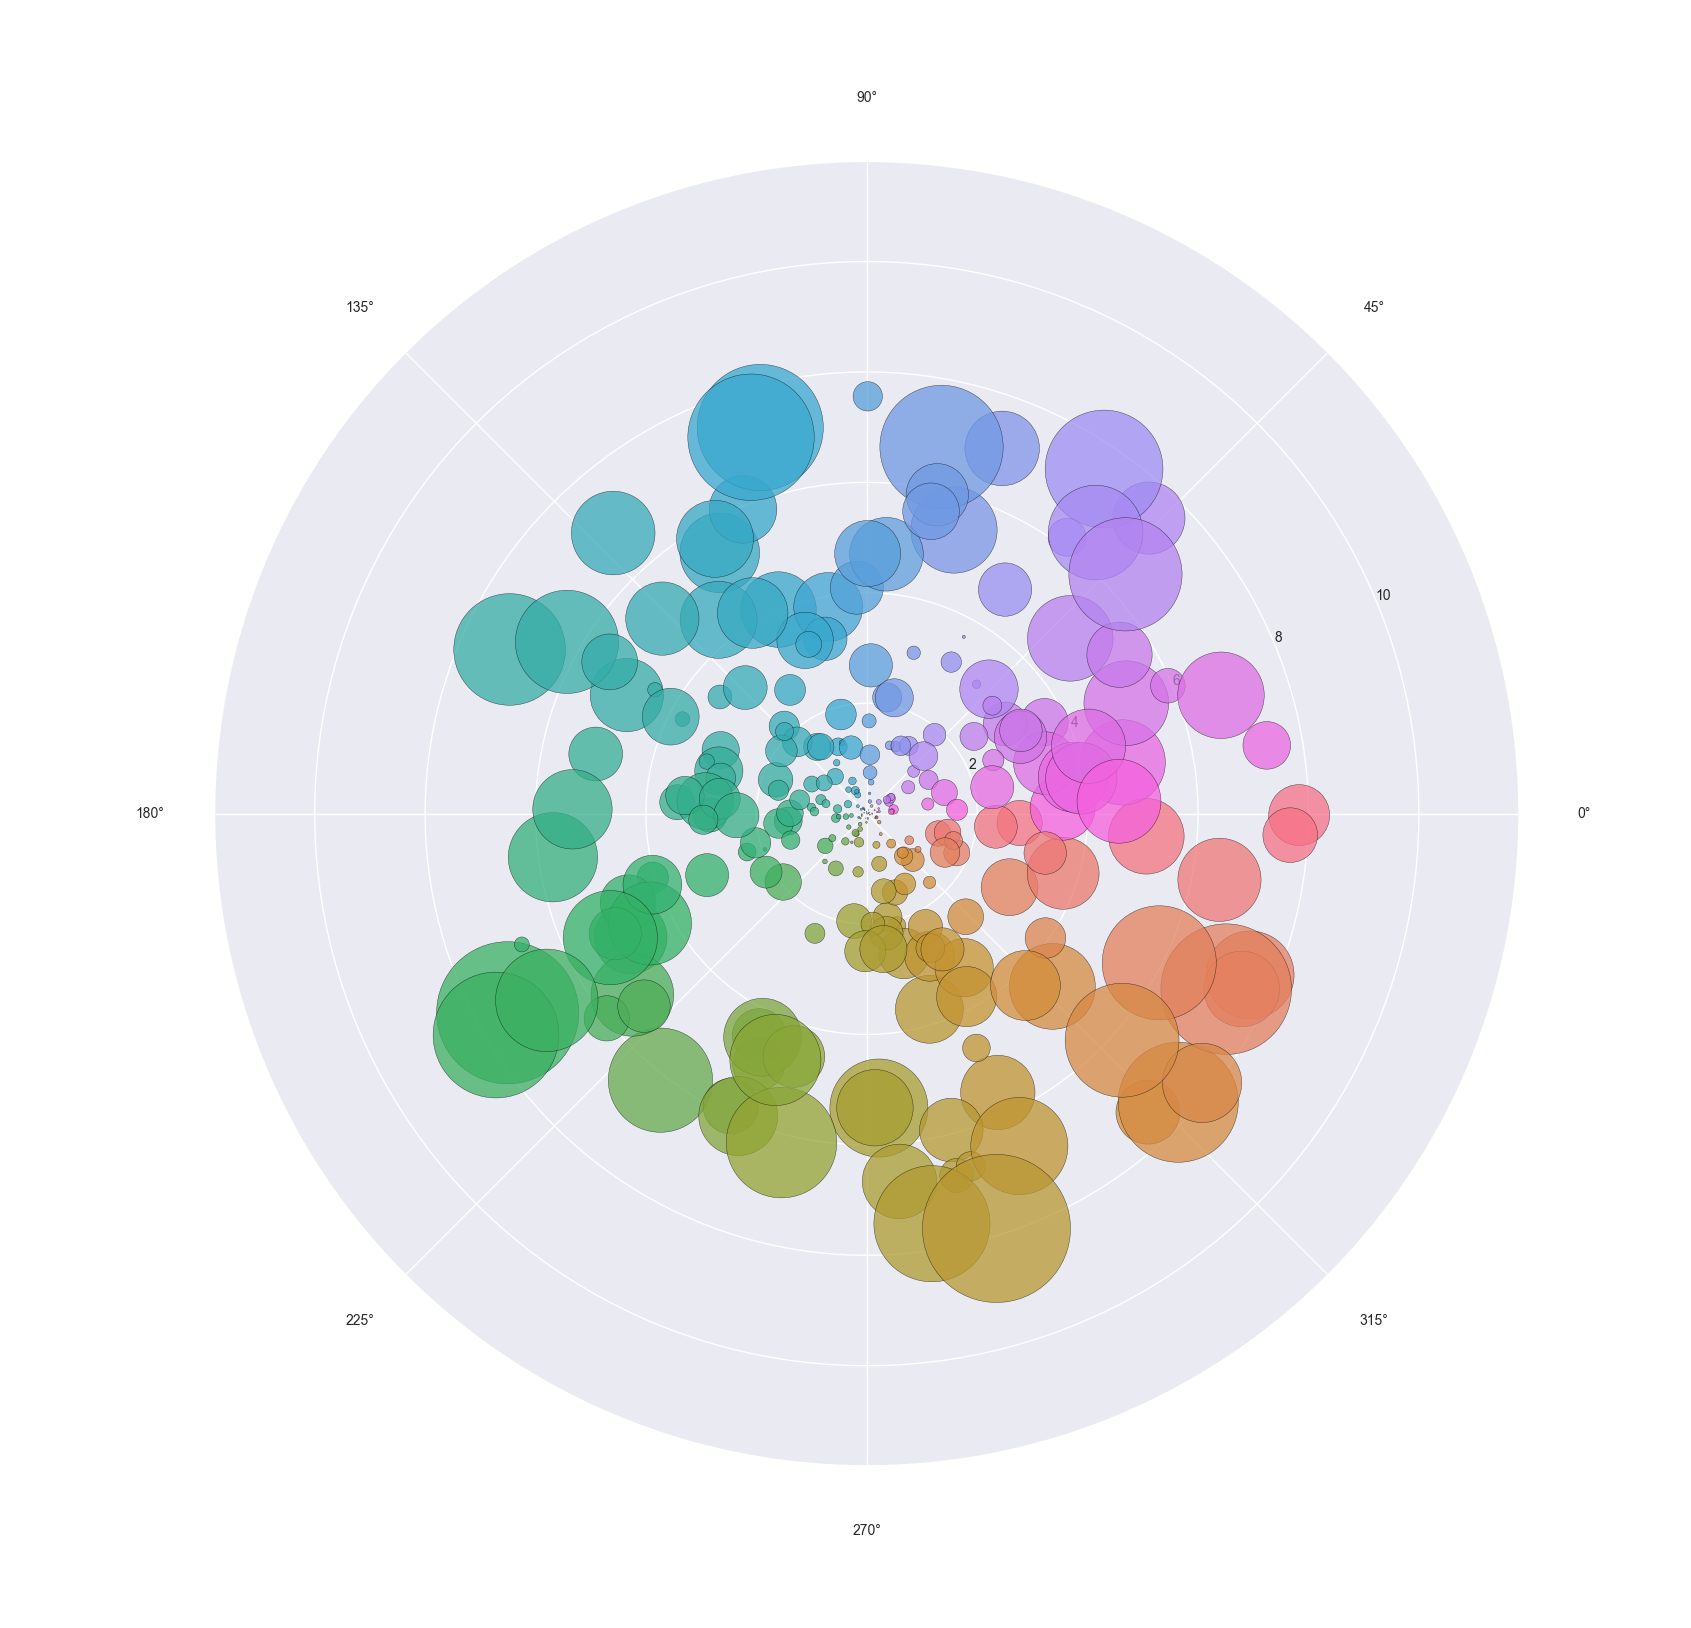

In [17]:
Image("figure_1.png")

The plot shoudl have the focus automatically. Press the right and left arrow keys to navigate through your data sets. You can return to the beginning of the data set by typing "r", the "reset" key. Play with it a bit, to convince yourself that it's really doing what we intended :-)

### Axes and Figure Events

In [18]:
def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()

class FigureAndAxesFocus:
    def __init__(self):
        (self.figure, (self.axes1, self.axes2)) = plt.subplots(2, 1)
        title = "Hover mouse over figure or its axes to trigger events"
        self.figure.suptitle(title)
        self.setup_figure_events()
        self.setup_axes_events()

    def start(self):
        plt.show()
        
    def setup_figure_events(self):
        self.figure.canvas.mpl_connect(
            "figure_enter_event", enter_figure)
        self.figure.canvas.mpl_connect(
            "figure_leave_event", leave_figure)

    def setup_axes_events(self):
        self.figure.canvas.mpl_connect(
            "axes_enter_event", enter_axes)
        self.figure.canvas.mpl_connect(
            "axes_leave_event", leave_axes)

Let's try it out:

In [19]:
faaf = FigureAndAxesFocus()
faaf.start()

enter_figure Figure(640x440)
enter_axes Axes(0.125,0.536364;0.775x0.363636)
leave_axes Axes(0.125,0.536364;0.775x0.363636)
enter_axes Axes(0.125,0.1;0.775x0.363636)
leave_axes Axes(0.125,0.1;0.775x0.363636)
enter_axes Axes(0.125,0.536364;0.775x0.363636)
leave_axes Axes(0.125,0.536364;0.775x0.363636)
enter_axes Axes(0.125,0.1;0.775x0.363636)
leave_axes Axes(0.125,0.1;0.775x0.363636)
leave_figure Figure(640x440)
enter_figure Figure(640x440)
leave_figure Figure(640x440)
enter_figure Figure(640x440)
enter_axes Axes(0.125,0.536364;0.775x0.363636)
leave_axes Axes(0.125,0.536364;0.775x0.363636)
enter_axes Axes(0.125,0.1;0.775x0.363636)
leave_axes Axes(0.125,0.1;0.775x0.363636)
enter_axes Axes(0.125,0.536364;0.775x0.363636)
leave_axes Axes(0.125,0.536364;0.775x0.363636)
leave_figure Figure(640x440)


### Object Picking

The next event we will mention is a special one: the event of an object being "picked". Every ``Artist`` instance (naturally including any subclassess of ``Artist``) has an attribute ``picker``. Setting this attribute is what enables object picking in matplotlib.

The definition of *picked* can vary, depending upon context. For instance, setting ``Artist.picked`` has the following results:
 * If ``True``, picking is enabled for the artist object and a ``pick_event`` will fire any time a mouse event occurs over the artist object in the figure.
 * If a number (e.g., ``float`` or ``int``), the value is interpreted as a "tolerance"; if the event's data (such as $x$ and $y$ values) is within the value of that tolerance, the ``pick_event`` will fire.
 * If a callable, then the provided function or method returns a boolean value which determines if the ``pick_event`` is fired.
 * If ``None``, picking is disabled.
 
The example below is adapted from the matplotlib project's [picking exercise](http://matplotlib.org/users/event_handling.html#picking-exercise) in the [Advanced User's Guide](http://matplotlib.org/users/developer.html). In it, we create a data set of 100 arrays, each containing 1000 random numbers. The sample mean and standard deviation of each is determined, and a plot is made of the 100 means vs the 100 standard deviations. We then connect the line created by the plot command to the pick event, and plot the original (randomly generated) time series data corresponding to the "picked" points. If more than one point is within the tolerance of the clicked on point, we display multiple subplots for the time series which fall into our tolerance (in this case, 10 pixels).

In [20]:
class DataPicker:
    def __init__(self, range):
        self.range = range
        self.figure = self.axes = self.line = None
        self.xs = np.random.rand(*self.range)
        self.means = np.mean(self.xs, axis=1)
        self.stddev = np.std(self.xs, axis=1)

    def start(self):
        self.create_main_plot()
        self.figure.canvas.mpl_connect('pick_event', self.handle_pick)
        plt.show()

    def create_main_plot(self):
        (self.figure, self.axes) = plt.subplots()
        self.axes.set_title('click on point to plot time series')
        (self.line,) = self.axes.plot(self.means, self.stddev, 'o', picker=10)

    def create_popup_plot(self, n, event):
        popup_figure = plt.figure()
        for subplotnum, i in enumerate(event.ind):
            popup_axes = popup_figure.add_subplot(n, 1, subplotnum + 1)
            popup_axes.plot(self.xs[i])
            text_data = (self.means[i], self.stddev[i])
            popup_axes.text(
                0.05, 0.9,
                '$\mu$=%1.3f\n$\sigma$=%1.3f' % text_data,
                transform=popup_axes.transAxes, va='top')
            popup_axes.set_ylim(-0.5, 1.5)
        popup_figure.show()

    def handle_pick(self, event):
        if event.artist != self.line:
            return
        n = len(event.ind)
        if not n:
            return
        self.create_popup_plot(n, event)

In [21]:
dp = DataPicker(range=(100,1000))
dp.start()

## Compound Event Handling

This section discusses the combination of multiple events or other sources of data in order to provide a more highly customized user experience, whether that be for visual plot updates, preparation of data, setting object properties, or updating widgets. This is what we will refer to as "compound events".

### Navigation Toolbar

matplotlib backends come with a feature we haven't discussed yet: a widget for [interactive navigation](http://matplotlib.org/users/navigation_toolbar.html). This widget is available for all the backends (including the ``nbagg`` backend for IPython, when not in "inline" mode). In brief, the functionality associated with the buttons in the widget is as follows:
 * *Home*: returns the figure to its originally rendered state
 * *Previous*: return to the previous view in the plot's history
 * *Next*: move to the next view in the plot's history
 * *Pan/Zoom*: pan across the plot by clicking and holding the left mouse button; zoom by clicking and holding the right mouse button (behavior differs between Cartesian and Polar plots)
 * *Zoom-to-Rectangle*: zoom in on a selected portion of the plot
 * *Subplot Configuration*: configure the display of subplots via a pop-up widget with various parameters
 * *Save*: save the plot, in its currently displayed state, to a file
 
When a toolbar action is engaged, the ``NavigationToolbar`` instance sets the current mode. For instance, when the *Zoom-to-Rectangle* button is clicked, the mode will be set to ``zoom rect``. When in *Pan/Zoom*, the mode will be set to ``pan/zoom``. These can be used in conjunction with the supported events to fire callbacks in response to toolbar activity.

In point of fact, the toolbar class, ``matplotlib.backend_bases.NavigationToolbar2`` is an excellent place to look for examples of "compound events". Let's examine the *Pan/Zoom* button. The class tracks the following via attributes that get set:
 * The connection id for a "press" event
 * The connection id for a "release" event
 * The connection id for a "mouse move" event (correlated to a mouse drag later)
 * Whether the toolbar is "active"
 * What the toolbar mode is
 * What the zoom mode is

During toolbar setup, toolbar button events are connected to callbacks. When these buttons are pressed, and the callbacks are fired, old events are disconnected and new ones connected. In this way, chains of events may be set up with a particular sequence of events firing only a particular set of callbacks and in a particular order.

### Specialized Events

The code in ``matplotlib.backend_bases.NavigationToolbar2`` is a great place to go to get some ideas about how you might combine events in your own projects. You might have a workflow that requires responses to plot updates, but only if a series of other events has taken place first. You can accomplish these by connecting events to and disconnecting them from various callbacks.

### Interactive Panning and Zooming

Let's go back to the toolbar for a practical example of creating a compound event.

The problem we want to address is this: when a user pans or zooms out of the range of previously computed data in a plotted area, they are presented with parts of an empty grid with no visualization. It would be nice if we could put our new-found event callback skills to use in order to solve this issue.

Let's look at an example where it would be useful to have the plot figure refreshed when it is moved: a topographic map. Geophysicsist Joe Kington has provided some nice answers on Stackoverflow regarding matplotlib in the context of terrain gradients. In [one particular example](http://stackoverflow.com/a/16531438), he showed how to view the flow of water from random wells on a topographic map. We're going to do a couple of things with this example:

* add a color map to give it the look of a physical map
* give altitude in meters, and most importantly,
* create a class that can update the map via a method call

Our custom color map and Joe's equations for generating a topographical map have been saved to ``./lib/topo.py``. We'll need to import those. Then we can define ``TopoFlowMap``, our wrapper class that will be used to update the plot when we pan:

In [22]:
class TopoFlowMap:
    def __init__(self, xrange=None, yrange=None, seed=1):
        self.xrange = xrange or (0,1)
        self.yrange = yrange or (0,1)
        self.seed = seed
        (self.figure, self.axes) = plt.subplots(figsize=(12,8))
        self.axes.set_aspect(1)
        self.colorbar = None
        self.update()

    def get_ranges(self, xrange, yrange):
        if xrange:
            self.xrange = xrange
        if yrange:
            self.yrange = yrange
        return (xrange, yrange)

    def get_colorbar_axes(self):
        colorbar_axes = None
        if self.colorbar:
            colorbar_axes = self.colorbar.ax
            colorbar_axes.clear()
        return colorbar_axes
    
    def get_filled_contours(self, coords):
        return self.axes.contourf(cmap=topo.land_cmap, *coords.values())

    def update_contour_lines(self, filled_contours):
        contours = self.axes.contour(filled_contours, colors="black", linewidths=2)
        self.axes.clabel(contours, fmt="%d", colors="#330000")

    def update_water_flow(self, coords, gradient):
        self.axes.streamplot(
            coords.get("x")[:,0],
            coords.get("y")[0,:],
            gradient.get("dx"),
            gradient.get("dy"),
            color="0.6",
            density=1,
            arrowsize=2)
        
    def update_labels(self):
        self.colorbar.set_label("Altitude (m)")
        self.axes.set_title("Water Flow across Land Gradients", fontsize=20)
        self.axes.set_xlabel("$x$ (km)")
        self.axes.set_ylabel("$y$ (km)")

    def update(self, xrange=None, yrange=None):
        (xrange, yrange) = self.get_ranges(xrange, yrange)
        (coords, grad) = topo.make_land_map(self.xrange, self.yrange, self.seed)
        self.axes.clear()
        colorbar_axes = self.get_colorbar_axes()
        filled_contours = self.get_filled_contours(coords)
        self.update_contour_lines(filled_contours)
        self.update_water_flow(coords, grad)
        self.colorbar = self.figure.colorbar(filled_contours, cax=colorbar_axes)
        self.update_labels()

Let's switch back to the IPython Notebook backend, so we have a reference image saved in the notebook:

In [23]:
plt.switch_backend('nbAgg')

Let's draw the topographical map next, without any ability to update when panning:


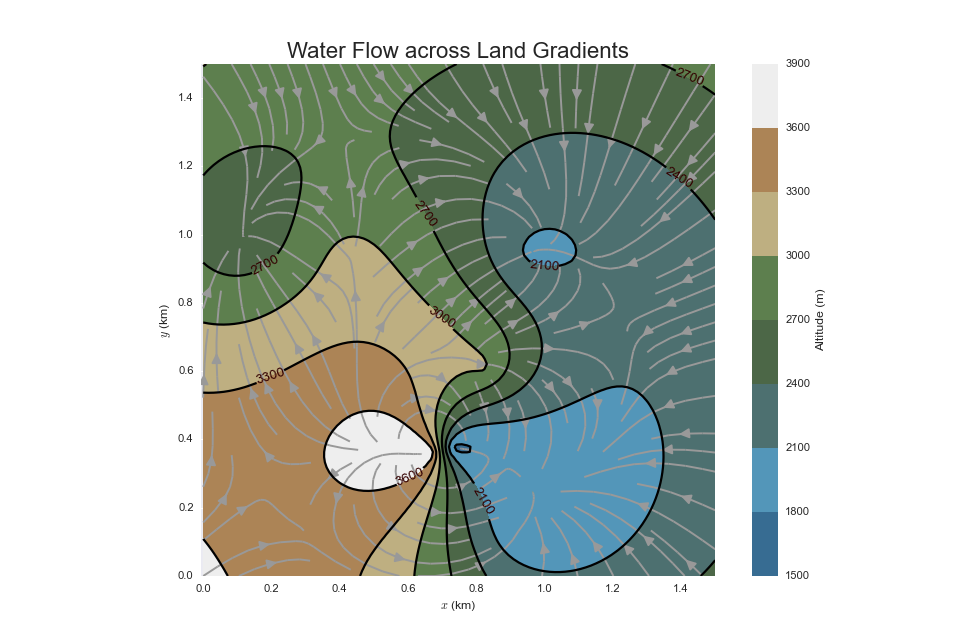

In [24]:
tfm = TopoFlowMap(xrange=(0,1.5), yrange=(0,1.5), seed=1732)
plt.show()

If you click the "pan/zoom" button on the navigation toolbar, and then click+hold on the figure, you can move it about. Note that, when you do so, nothing gets redrawn.

Since we do want to redraw, and there is no "pan event" to connect to, what are our options? Well, two come to mind:
 * piggy back on the ``draw_event``, which fires each time the canvas is moved, or
 * use the ``button_release_event`` which will fire when the panning is complete
 
If our figure was easy to draw with simple equations, the first option would probably be fine. However, we're doing some multivariate calculus on our simulated topography; as you might have noticed, our plot does not render immediately. So let's go with the second option.

There's an added bonus, though, that will make our lives easier: the ``NavigationTool2`` keeps track of the mode it is in on it's ``mode`` attribute. Let's use that to save some coding!

In [25]:
class TopoFlowMapManager:
    def __init__(self, xrange=None, yrange=None, seed=1):
        self.map = TopoFlowMap(xrange, yrange, seed)
        _ = self.map.figure.canvas.mpl_connect(
            'button_release_event', self.handle_pan_zoom_release)

    def start(self):
        plt.show()
        
    def handle_pan_zoom_release(self, event):
        if event.canvas.toolbar.mode != "pan/zoom":
            return
        self.map.update(event.inaxes.get_xlim(),
                        event.inaxes.get_ylim())
        event.canvas.draw()

Let's switch back to the native backend (in my case, that's ``MacOSX``; you may need ``Qt5Agg``, ``WXAgg``, or ``GTK3Agg``):

In [26]:
plt.switch_backend('MacOSX')

Run the next bit of code, and then start panning around and releasing; you should see the new data displayed after the callbacks fires off the recalculation.

In [27]:
tfmm = TopoFlowMapManager(xrange=(0,1.5), yrange=(0,1.5), seed=1732)
tfmm.start()

This is not a perfect topographical model, so sometimes you will see colors get shifted as the range of altitudes decreases or increases in a given view. Certainly close enough to demonstrate this use case, though :-)

Another thing you could do is add support for ``zoom rect`` such that the contour lines don't get angled (due to sparse data sample spacing), but stay smoothly curved no matter how far you zoom in. Given the example above, that should be fairly easy to implement, and we leave it as a fun exercise for the motivated reader :-)